# Predicting delivery duration with Machine Learning

# Derien Weatherspoon

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience.

Goal: Create machine learning model(s) to predict delivery duration in seconds. Be sure to explain: model(s) used, how I evaluated model performance on the historical data, any data processing, feature engineering choices made, and any other relevant information regarding the model.

Methodology: In order to achieve success in this project, we will employ two model types, linear regression and light gradient-boosting machine (LGBM). The performance metric used evaluated is the RMSE (root mean squared error), calculating the accuracy of predicted delivery duration.

In [68]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Import libraries

In [69]:
# libraries will besides numpy, pandas seaborn, and matplotlib will be imported as needed and moved here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# datetime dependency
from datetime import datetime

# VIF dependency
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Random Forest dependencies
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Scaling and Dimensionality dependencies
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# MSE dependency
from sklearn.metrics import mean_squared_error

# Regression dependencies
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

# Deep Learning dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

## Data and EDA

The data set used for this project is publicly available on [stratascratch](https://platform.stratascratch.com/data-projects/delivery-duration-prediction), a website used to complete coding questions and data projects. The file `historical_data.csv` contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. There is added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`. So `total_delivery_duration` = `actual_delivery_time` - `created_at`.

The data set has the following features:

- Time features:

    - `market_id`: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
    - `created_at`: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
    - `actual_delivery_time`: Timestamp in UTC when the order was delivered to the consumer


- Store features:

    - `store_id`: an id representing the restaurant the order was submitted for
    - `store_primary_category`: cuisine category of the restaurant, e.g., italian, asian
    - `order_protocol`: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

                                                                           
- Order features:
                                                                           
    - `total_items`: total number of items in the order
    - `subtotal`: total value of the order submitted (in cents)
    - `num_distinct_items`: number of distinct items included in the order
    - `min_item_price`: price of the item with the least cost in the order (in cents)
    - `max_item_price`: price of the item with the highest cost in the order (in cents)

  
- Market features: DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of `created_at` (order submission time):

    - `total_onshift_dashers`: Number of available dashers who are within 10 miles of the store at the time of order creation
    - `total_busy_dashers`: Subset of above total_onshift_dashers who are currently working on an order
    - `total_outstanding_orders`: Number of orders within 10 miles of this order that are currently being processed.

    
- Predictions from other models: There are predictions from other models for various stages of delivery process that we can use:

    - `estimated_order_place_duration`: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
    - `estimated_store_to_consumer_driving_duration`: Estimated travel time between store and consumer (in seconds)


In [2]:
# load in data as pandas df (generic, I know)
df = pd.read_csv('historical_data.csv')

In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
# find info on the data, ensure the data type is correct for each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

Notice that the two datetime feature needed to create our target feature are not yet encoded as datetime features.

In [5]:
# convert date time features
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

<AxesSubplot:>

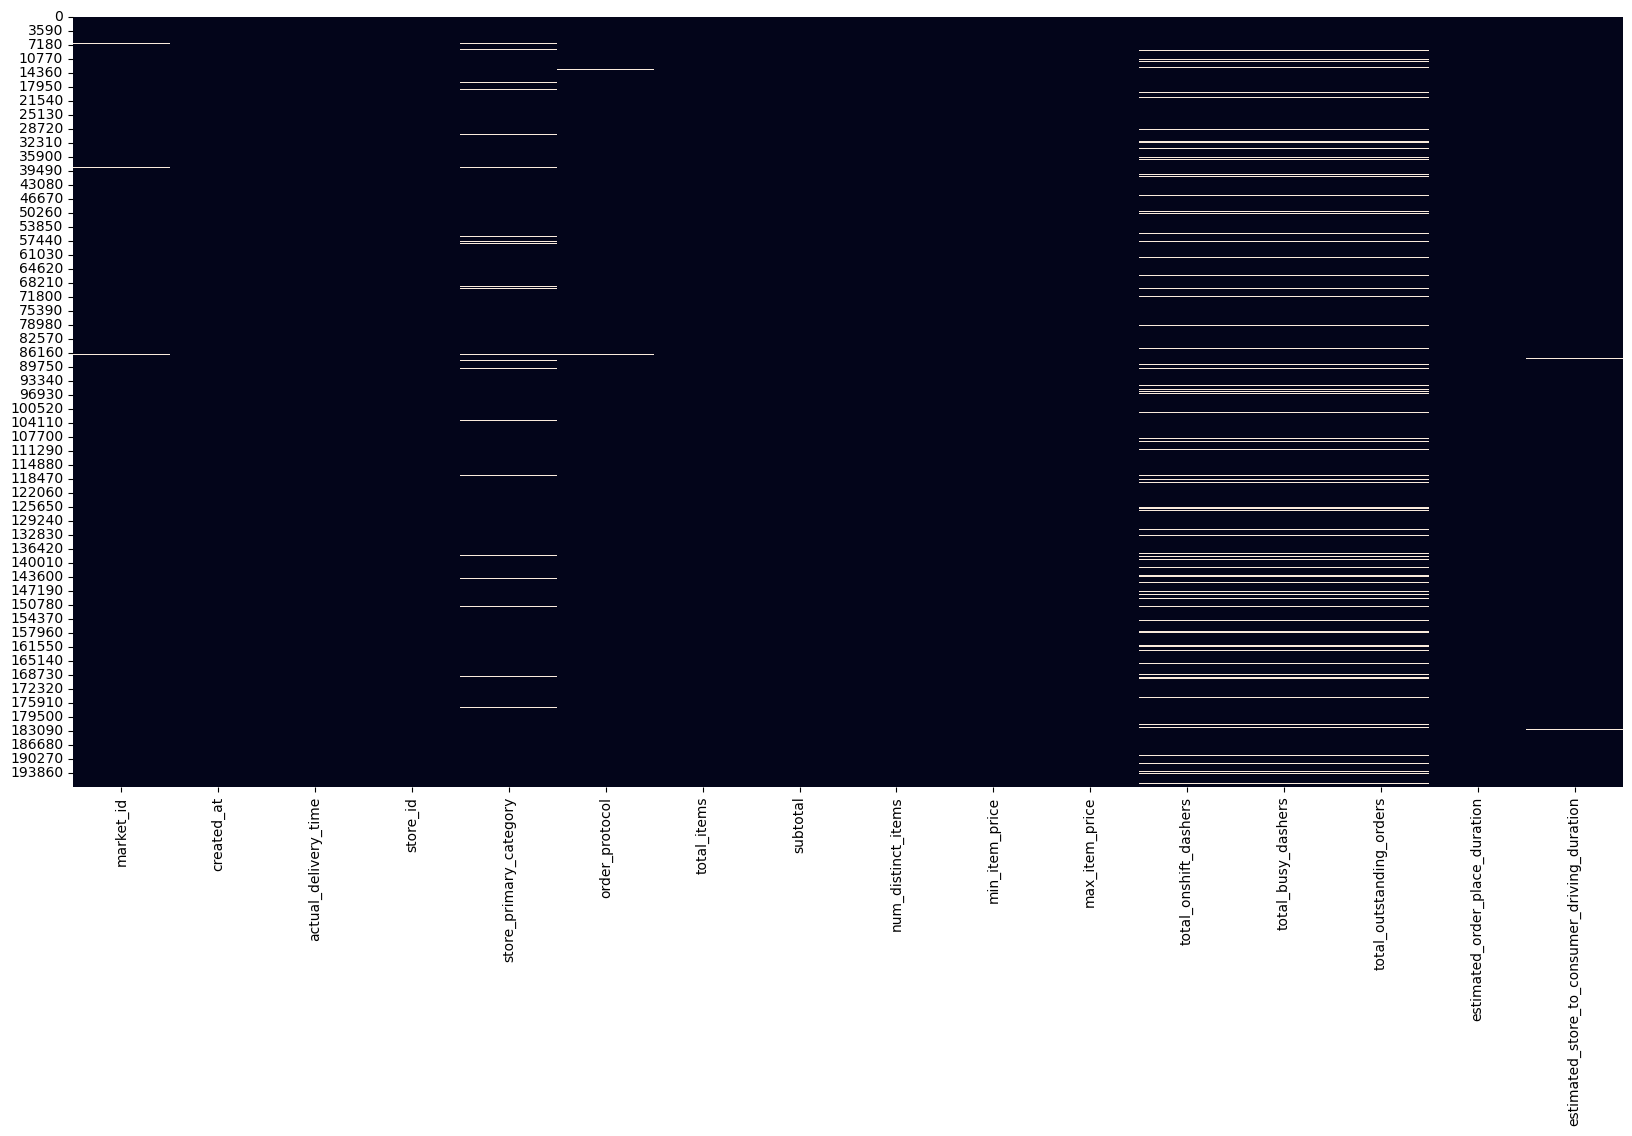

In [6]:
# let's show missing values with white color
plt.figure(figsize=(20, 10)) 
sns.heatmap(df.isnull(), cbar=False)

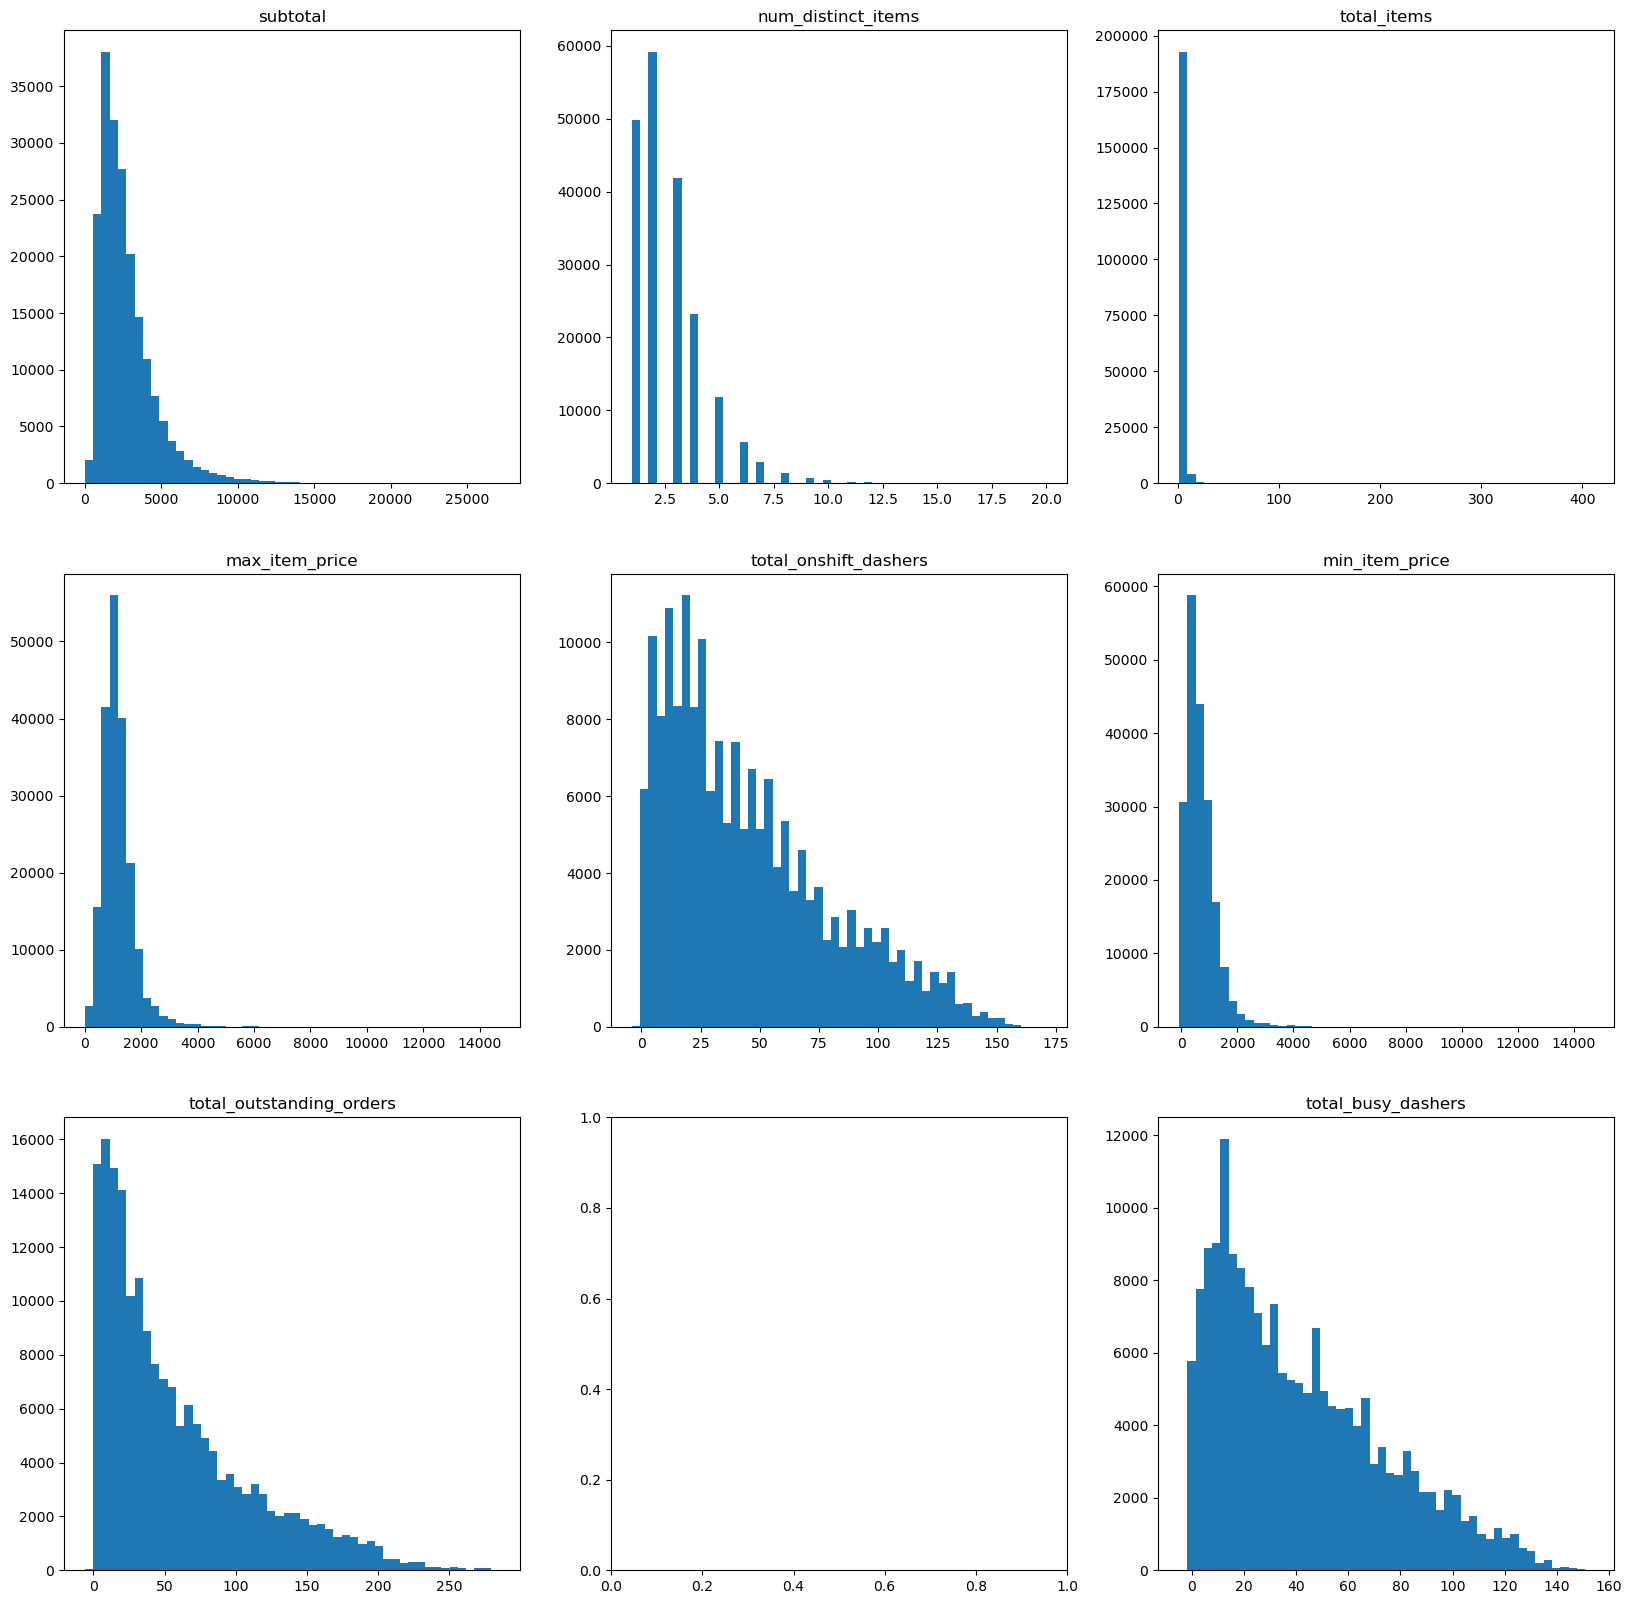

In [74]:
# numeric feature distribution
numerics = ['total_items',  'subtotal', 'num_distinct_items', 'min_item_price','max_item_price','total_onshift_dashers','total_busy_dashers','total_outstanding_orders']
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i,n in enumerate(numerics):
    axes[i//3][(i%3)-1].hist(df[n],bins=50)
    axes[i//3][(i%3)-1].set_title(n)

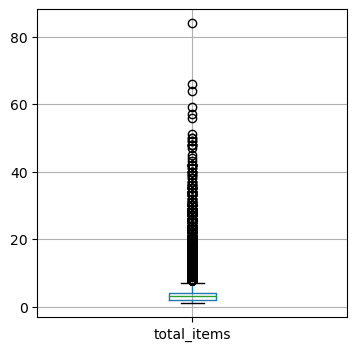

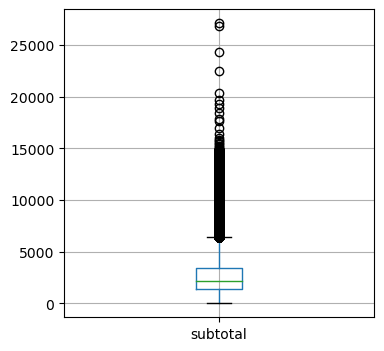

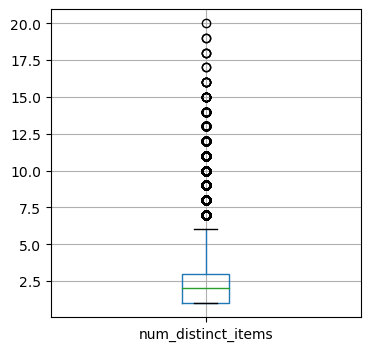

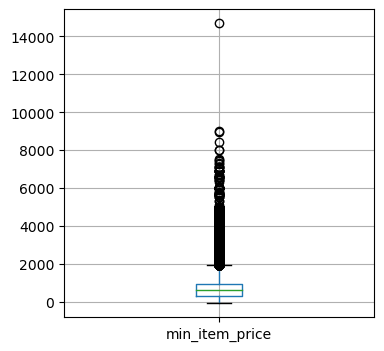

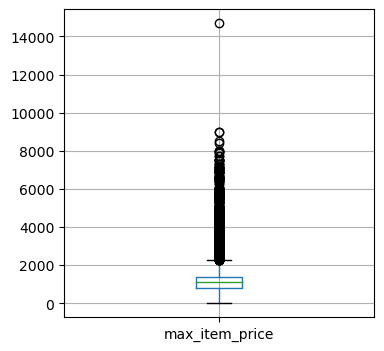

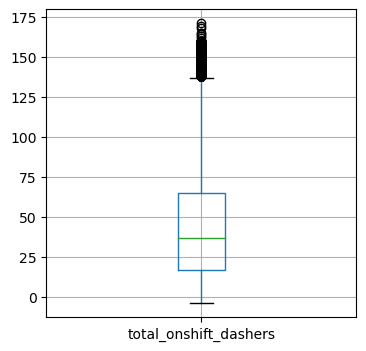

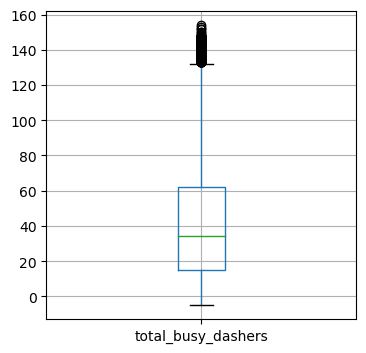

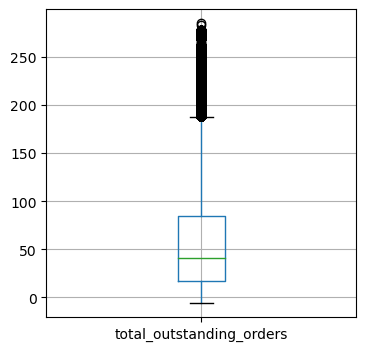

In [178]:
# checking the scale of outliers

for i in (numerics):
    boxplt = df.boxplot(column=[i], figsize = (4, 4))
    plt.show()

### Dealing with visible outliers

<AxesSubplot:>

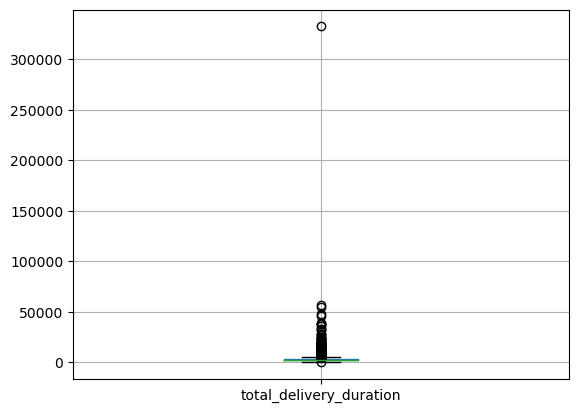

In [94]:
df.drop(df.loc[df['total_items']==411].index, inplace=True) # drop outlier from total items

df = df.drop([2690]) # drop delivery time outlier

boxplt = df.boxplot(column=['total_delivery_duration'])
boxplt

In [176]:
df['total_delivery_duration'].max() # drop the max outlier, 373879.0

df[df['total_delivery_duration'] == 373879.0]

df = df.drop([185550]) # drop delivery outlier

KeyError: '[185550] not found in axis'

In [108]:
df['total_delivery_duration'].max() # checking the other max value now after dropping the first one

df[df['total_delivery_duration'] == 332482.0]

df = df.drop([27189]) # dropping the next value

## Feature creation

The target feature here is `actual_delivery_time` - `created_at`.

Furthermore, since the total number of available dashers within a certain area is subject to change, we will create the feature called `busy_dashers_ratio`, which is `total_busy_dashers` / `total_onshift_dashers`

Our third feature to create is `estimated_non_prep_duration`, which is `estimated_store_to_consumer_driving_duration` + `estimated_order_place_duration`. This is important to figure out because we are already given the estimated the restaurant receives an order from DoorDash and the estimated time it takes for the store to deliver the meal to the consumer. These two features impact the delivery duration.

In [109]:
# create target feature
df['total_delivery_duration'] = (df['actual_delivery_time'] - df['created_at'])

# make sure target feature is in seconds
df['total_delivery_duration'] = df['total_delivery_duration'].dt.total_seconds() # datetime

# create busy dashers ratio feature
df['busy_dashers_ratio'] = df['total_busy_dashers'] / df['total_onshift_dashers']

# create non-preparation duration feature
df['estimated_non_prep_duration'] = df['estimated_store_to_consumer_driving_duration'] + df['estimated_order_place_duration'] 

### Data Preparation for Modeling

A common way to prepare data for modeling is to one hot encode some features. But before we try that, check if it makes sense to do so first.

In [110]:
# check id features to see if encoding makes sense
df['market_id'].nunique()

6

In [111]:
df['store_id'].nunique()

6743

In [112]:
df['order_protocol'].nunique()

7

It makes sense to encode `market_id` and `order_protocol`, but not `store_id`.

In [113]:
# create dummies for order_protocol 
order_protocol_dummies = pd.get_dummies(df.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [114]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(df.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


Now that we have dummy variables for those two features, and `store_id` doesn't need to have any, we can look back at `store_primary_category`, which had tons of missing values. We will impute by the most common category for each store (Imputing by mode). This can be done by creating a reference dictionary. A reference dictionary will map each `store_id` to the most frequent `cuisine_category` they have.

In [115]:
# create reference dictionary with the most repeated categories of each store
store_id_unique = df['store_id'].unique().tolist()
store_id_and_category = {store_id: df[df.store_id == store_id].store_primary_category.mode() 
                        for store_id in store_id_unique}

In [116]:
# function to impute values
def impute(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
# fill null values
df["nan_free_store_primary_category"] = df.store_id.apply(impute)

In [117]:
# create dummies for store_primary_category
store_primary_category_dummies = pd.get_dummies(df.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that the data is properly prepared, we can now create the training data set, without the features `created_at`, `market_id`, `store_primary_category`, `actual_delivery_time`, and `nan_free_store_primary_category`.

In [118]:
train_df = df.drop(columns = 
['created_at', 'market_id', 'store_primary_category', 'actual_delivery_time', 'nan_free_store_primary_category'])
train_df.head()

,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,1845,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,5477,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,5477,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,5477,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,5477,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [119]:
# concat all columns together
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)

# convert data type to float for future models
train_df = train_df.astype("float32")
train_df.head()

,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,1845.0,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5477.0,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5477.0,1.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5477.0,1.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5477.0,1.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
# find any mathematical descriptions on the the data
train_df.describe()

,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197424.000000,196429.000000,197424.000000,197424.000000,197424.000000,197424.000000,197424.000000,181163.000000,181163.000000,181163.000000,...,197424.000000,197424.000000,197424.000000,197424.000000,197424.000000,197424.000000,197424.000000,197424.000000,197424.000000,197424.000000
mean,3530.504883,2.882344,3.194333,2682.328125,2.670780,686.218079,1159.589722,44.808243,41.739868,58.050236,...,0.000816,0.000187,0.005465,0.011301,0.000740,0.037255,0.001175,0.001433,0.004235,0.030928
std,2053.488037,1.503762,2.503787,1822.977051,1.629399,522.066040,558.357117,34.524246,32.145897,52.657494,...,0.028535,0.013688,0.073626,0.105706,0.027175,0.189504,0.034246,0.037816,0.064904,0.173169
min,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6987.000000,7.000000,84.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [121]:
train_df['busy_dashers_ratio'].describe()

count    1.775880e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

Since there are infite values here, we have to back and fix this! We divided a number by zero potentially when the function was made. To check this, we will use the following three nested functions below.

In [122]:
# checking infinity values using numpy
np.where(np.any(~np.isfinite(train_df), axis = 0) == True)

(array([ 1,  7,  8,  9, 11, 12, 13, 14]),)

In [123]:
# replace infinite values with NaN for easy removal
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# drop all NaNs
train_df.dropna(inplace=True)

In [124]:
train_df.shape

(176164, 102)

## Collinearity and Redundancy

Having 100+ columns in this data set. Sometimes big data sets can help our model, but more often than not it can hurt too. Since there's 102 columns, we'll have to remove some redunant columns. There are too many predictors, this will cause collinearity. 

What is collinearity? This means that the variables are correlated with each other. So these features have the same effect on the model, which means just one of them would be enough. Correlated features makes it hard to interpret the model and would hurt model performance. This is what we do NOT want. 

How can we determine correlated features? Simple, one of my favorite functions and visualizations to perform, use the `corr` method! 

<AxesSubplot:>

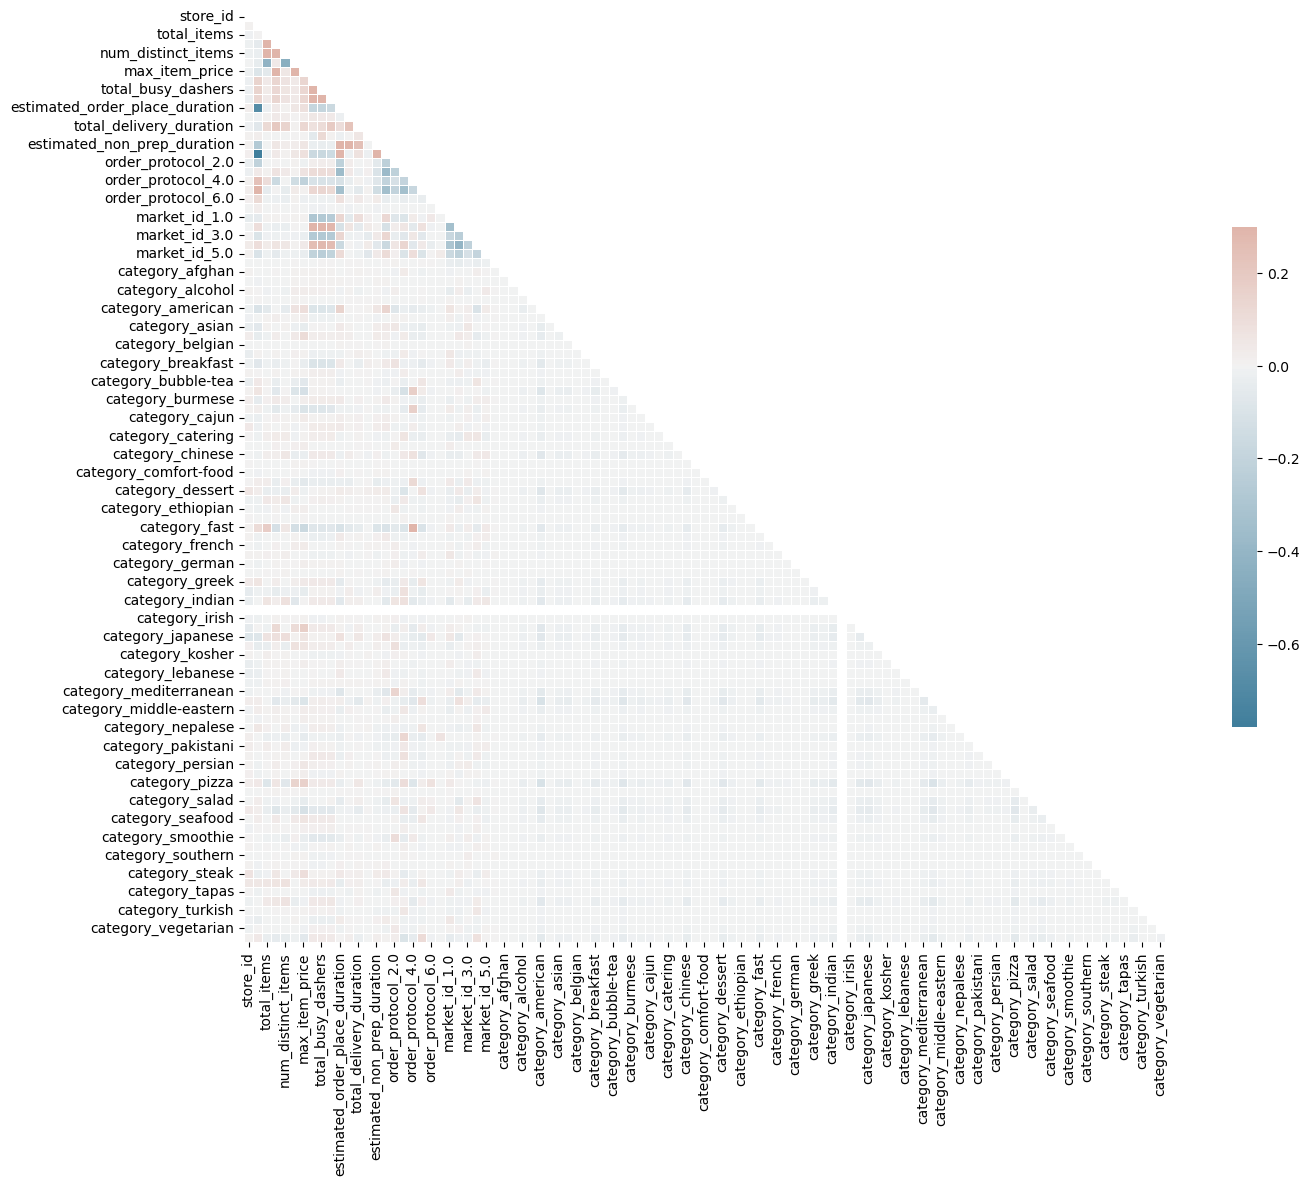

In [125]:
# masked correlation matrix
corr = train_df.corr()

# generate the mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))

# set up figure
f, ax = plt.subplots(figsize = (15,13))

# set up diverging palette
cmap = sns.diverging_palette(230, 20, as_cmap = True)

# form heatmap
sns.heatmap(corr, mask = mask, cmap = cmap, vmax= .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

Why use a mask? Correlation matrices repeat itself across the main diagonal. We can slice this half using a mask.

From the correlation heatmap above, it looks like there is an issue with `category_irish`. 

In [126]:
# investigate category_irish
train_df['category_irish'].describe()

count    176164.000000
mean          0.000301
std           0.017341
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: category_irish, dtype: float64

There are plenty of zeros with `category_irish`, so let's go ahead and drop this. Furthermore, we can make this easier on ourselves and create a function to get redundant values and a function to find top correlated features.

In [127]:
# function to get redunant values
def get_redundant_values(df):
    """Get diagonal and lower triangular values of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [128]:
# function to get top correlated values
def get_top_correlation(df, n = 5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack() # important to take the absolute value
    labels_to_drop = get_redundant_values(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

In [129]:
# use the functions to help sort and filter through redundant features and top correlated values
print('Top Absolute Correlations') 
print(get_top_correlation(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers                0.941754
                                              total_outstanding_orders          0.934653
total_busy_dashers                            total_outstanding_orders          0.931312
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration       0.923067
estimated_order_place_duration                order_protocol_1.0                0.900654
total_items                                   num_distinct_items                0.811966
order_protocol                                order_protocol_1.0                0.780826
                                              order_protocol_5.0                0.769004
                                              estimated_order_place_duration    0.687007
subtotal                                      num_distinct_items                0.682965
total_items                                   subtotal                          0.59

Lucky for us, this function gives us everything we need in order to remove redundancy! Even sorting in descending order. 

It appears that `total_onshift_dashers` and `total_busy_dashers` are redundant, as they are HIGHLY correlated. These are represented in the `busy_dashers_ratio` too.
The next pair that is highly correlated is `estimated_store_to_consumer_driving_duration` and `estimated_non_prep_duration`. Since we created `estimated_non_prep_duration`, we will drop this created feature and use the original in it's place.
Finally, it looks as if there is one more highly correlated pair(s) here. All of `market_id` are correlated with one another! So let's drop these.


In [130]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, nan_free_store_primary_category, order_protocol
train_df = df.drop(columns = ['created_at', 'store_id', 'market_id', 'store_primary_category', 'actual_delivery_time', 
                              'nan_free_store_primary_category', 'order_protocol'])
# now, add the dummies back in the data, except market_id
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis = 1)

# drop highly correlated features
train_df = train_df.drop(columns = ["total_onshift_dashers", "total_busy_dashers", 
                                    "category_irish", "estimated_non_prep_duration"])

In [131]:
# align data type over data set
train_df = train_df.astype("float32")

# replace infinite values with NaN to drop all NaNs
train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
train_df.dropna(inplace = True)

In [132]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
train_df.shape

(177068, 90)

For the sake of the models, we'll use the `get_top_correlations` function again to ensure everything is good.

In [134]:
print('Top Absolute Correlations') 
print(get_top_correlation(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration                order_protocol_1.0         0.897645
total_items                                   num_distinct_items         0.812093
subtotal                                      num_distinct_items         0.682891
total_items                                   subtotal                   0.597582
min_item_price                                max_item_price             0.541234
subtotal                                      max_item_price             0.507949
order_protocol_4.0                            category_fast              0.489906
num_distinct_items                            min_item_price             0.446732
total_items                                   min_item_price             0.416441
order_protocol_1.0                            order_protocol_3.0         0.373581
estimated_order_place_duration                order_protocol_3.0         0.364170
order_protocol_1.0                            order_protocol_5.0        

It looks like there remains a lot of correlated pairs, mainly `order_protocol`. It's a dummy feature, this is why we are not going to concatenate them. So now, let's drop the correlated features again and repeat the code.

In [135]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, nan_free_store_primary_category, order_protocol
train_df = df.drop(columns = ['created_at', 'store_id', 'market_id', 'store_primary_category', 'actual_delivery_time', 
                              'nan_free_store_primary_category', 'order_protocol'])
# now, add the dummies back in the data, except market_id (and now order_protocol_dummies)
train_df = pd.concat([train_df, store_primary_category_dummies], axis = 1)

# drop highly correlated features
train_df = train_df.drop(columns = ["total_onshift_dashers", "total_busy_dashers", 
                                    "category_irish", "estimated_non_prep_duration"])
# align data type over data set
train_df = train_df.astype("float32")

# replace infinite values with NaN to drop all NaNs
train_df.replace([np.inf, -np.inf], np.nan, inplace = True)
train_df.dropna(inplace = True)
train_df.head()
print('Top Absolute Correlations') 
print(get_top_correlation(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.812093
subtotal                                      num_distinct_items                0.682891
total_items                                   subtotal                          0.597582
min_item_price                                max_item_price                    0.541234
subtotal                                      max_item_price                    0.507949
num_distinct_items                            min_item_price                    0.446732
total_items                                   min_item_price                    0.416441
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.226059
subtotal                                      total_delivery_duration           0.206220
total_outstanding_orders                      total_delivery_duration           0.189082
total_items                                   category_fast                     0.17

Looks like there are still some correlated features! In order to fix this, we'll likely have to perform Feature Engineering! Feature Engineering is a technique that creates new variables to simplify the model and increase accuracy, by using the new features as predictors.

## Feature Engineering

In [136]:
# feature engineered features
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns = ["num_distinct_items", "subtotal"], inplace = True)
print("Top Absolute Correlations")
print(get_top_correlation(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860579
max_item_price                                avg_price_per_item                0.770378
min_item_price                                max_item_price                    0.541234
total_items                                   percent_distinct_item_of_total    0.473744
                                              min_item_price                    0.416441
                                              avg_price_per_item                0.331682
percent_distinct_item_of_total                avg_price_per_item                0.226675
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.226059
category_pizza                                avg_price_per_item                0.225510
total_outstanding_orders                      total_delivery_duration           0.189082
total_items                                   category_fast                     0.17

After feature engineering, it looks like there are still issues with `min_item_price` and `max_item_price`. So let's create a new feature between these two.

In [137]:
# new feature: price range
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns = ["max_item_price", "min_item_price"], inplace = True)
print("Top Absolute Correlations")
print(get_top_correlation(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.473744
                                              price_range_of_items              0.357916
                                              avg_price_per_item                0.331682
percent_distinct_item_of_total                avg_price_per_item                0.226675
estimated_store_to_consumer_driving_duration  total_delivery_duration           0.226059
category_pizza                                avg_price_per_item                0.225510
total_outstanding_orders                      total_delivery_duration           0.189082
total_items                                   category_fast                     0.178716
category_fast                                 avg_price_per_item                0.175910
total_outstanding_orders                      estimated_order_place_duration    0.171048
category_italian                              avg_price_per_item                0.15

In [138]:
train_df.shape

(177068, 82)

Great! The correlation issues are solved and our data set has finally dropped below 100 columns. Now we can finally move on to the next task.

## Multicollinearity and Feature Selection

Multicollinearity is when one predictor variable in a multiple regression model can be predicted from other variables. Multicollinearity is a problem because it undermines the statistical significance of an independent variable, can cause issues like overfitting, and makes the model harder to interpret overall. The larger the standard error of a regression coefficient, the less likely it is that this coefficient will be statistically significant.

To deal with multicollinearity here, we will employ a variable inflation factor, which quantifies the severity of multicollinearity. Features with a variable inflation factor of 5 or higher will get removed. A VIF value less than 5 is often considered an acceptable threshold, indicating that multicollinearity is not a major concern.

In [139]:
# function to compute variable inflation factor
def compute_vif(features):
    """Compute VIF score"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features # column of feature names
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))] # column of VIF score
    return vif_data.sort_values(by=["VIF"]).reset_index(drop = True)

In [140]:
# apply function to all columns
features = train_df.drop(columns = ["total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000376
1,category_chocolate,1.000496
2,category_belgian,1.000753
3,category_russian,1.003291
4,category_african,1.003837
...,...,...
76,category_american,7.123943
77,estimated_store_to_consumer_driving_duration,7.203619
78,estimated_order_place_duration,13.447608
79,percent_distinct_item_of_total,31.061779


It appears that the feature `percent_distinct_item_of_total`, `estimated_order_place_duration`, and `estimated_store_to_consumer_driving_duration` are among some of the features  with a VIF score above 5. These and a few others are the futures that will get removed! Also, `category_indonesian` is NaN, so it will likely ge removed as well.

In [141]:
# removing features with a high VIF score using a while loop

multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data["feature"].values.tolist()[-1]
    print("I am removing", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 5]) == 0 else True

selected_features = vif_data["feature"].values.tolist()
vif_data

I am removing category_indonesian
I am removing percent_distinct_item_of_total
I am removing estimated_order_place_duration
I am removing estimated_store_to_consumer_driving_duration
I am removing busy_dashers_ratio
I am removing avg_price_per_item


,feature,VIF
0,category_chocolate,1.000004
1,category_alcohol-plus-food,1.000006
2,category_belgian,1.000017
3,category_comfort-food,1.000123
4,category_gluten-free,1.000203
...,...,...
70,category_pizza,1.268047
71,category_mexican,1.274481
72,price_range_of_items,2.290813
73,total_outstanding_orders,2.426852


All of the features with a VIF of over 5 are now removed. The features removed are: `category_indonesian` (NaN), `percent_distinct_item_of_total`, `estimated_order_place_duration`, `estimated_store_to_consumer_driving_duration`, `busy_dashers_ratio`, and `avg_price_per_item`.

## Feature Selection

Feature selections goal is to reduce the dimensions of a dataset, getting rid of the features that don't have a significant effect on the model. Furthermore, feature selection helps the algorithm work faster!

To employ feature selection, one can use techniques like PCA and Random Forest(a personal favorite of mine, as a student of statistics). Random Forest measures the imporance of each feature.

In [142]:
# apply train_test_split

X = train_df[selected_features] # from multicollinearity checking
y = train_df["total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

### Random Forest 

Random Forest measures the importance of each feature.

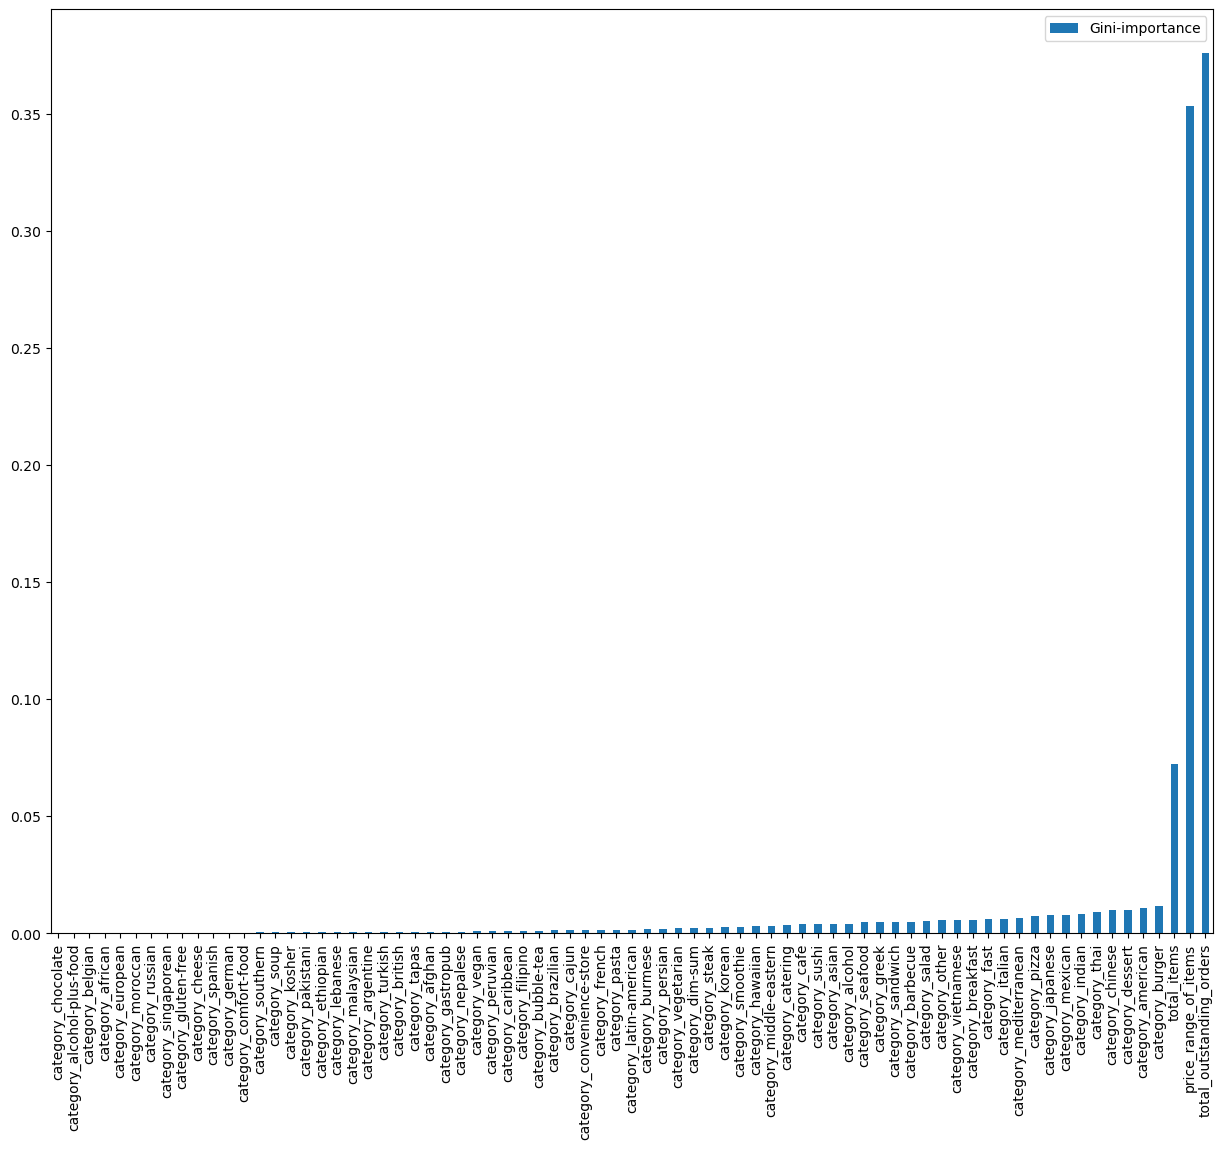

In [143]:
# apply Random Forest

feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

feats = {} # dict to hold feature importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance # add name/value pair
importances = pd.DataFrame.from_dict(feats, orient = 'index').rename(columns = {0: 'Gini-importance'})
importances.sort_values(by = 'Gini-importance').plot(kind = 'bar', rot = 90, figsize = (15,12))
plt.show()
                                                                                

From the graph, the features `total_items`, `total_outstanding__orders`, and `price_range_of_items` are found to be important features for the model. Also, it looks as if many features have a slight importance to the model. Since so many features have an effect, we will get the 20 most important features.

In [144]:
# obtain column names as test

importances.sort_values(by = 'Gini-importance')[-20:].index.tolist()

['category_barbecue',
 'category_salad',
 'category_other',
 'category_vietnamese',
 'category_breakfast',
 'category_fast',
 'category_italian',
 'category_mediterranean',
 'category_pizza',
 'category_japanese',
 'category_mexican',
 'category_indian',
 'category_thai',
 'category_chinese',
 'category_dessert',
 'category_american',
 'category_burger',
 'total_items',
 'price_range_of_items',
 'total_outstanding_orders']

Now that we have the 20 most important features, we will try a 2nd attempt to diminish the amount of features we have. PCA is the next step!

### PCA: Principal Component Analysis

PCA is a statistical procedure that allows you to summarize the information content in large data tables by means of a smaller set of “summary indices” that can be more easily visualized and analyzed. To interpret each principal components, examine the magnitude and direction of the coefficients for the original variables. The larger the absolute value of the coefficient, the more important the corresponding variable is in calculating the component. 

In short, it helps us find a optimum number of features to represent our data set.

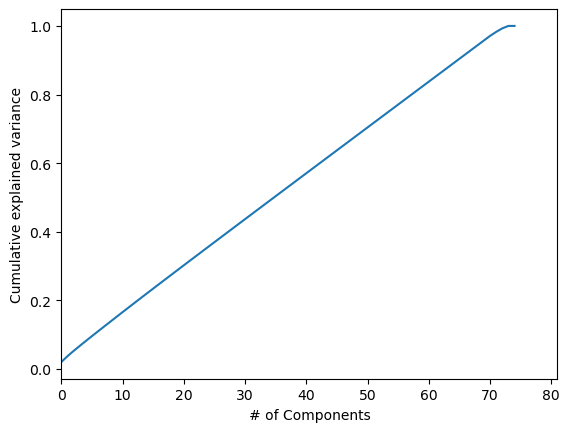

In [145]:
# Principal Component Analysis

X_Train = X_train
X_train = np.asarray(X_Train)

# finding normalized array of X_Train
X_std = StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 81, 1)
plt.xlabel('# of Components')
plt.ylabel('Cumulative explained variance')
plt.show()

The resulting graph above tells us that by using 60% of the features the data set can be explained by 80%. Since we have 75 features right now, we can continue using a Scaler.

Why use a scaler? Developing a model to make further interpretation, scaling is important, since it will be hard to compare the differently scaled features. Some optimization algorithms like gradient descent work better post scaling as well. When the values of the features are close, the model is more likely to be happy!

To perform scaling, we will use 2 methods. Standard Scaler and MIN/MAX Scaling.

### Standard Scaler

To calculate Standard Scaler, subtract the mean and divide that by the standard deviation. The goal is the make the mean 0, that's when our model will perform best.

### Min/Max Scaler / Normalization

Scales the features between 0 and 1 by subtracting minimum and maximum and dividing that by the difference between maximum and minimum.

In [146]:
# scale function

def scale(scaler, X, y):
    """Apply the selected scaler to features and target variable"""
    X_scaler = scaler
    X_scaler.fit(X = X, y = y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, X_scaler, y_scaler

# when we rename the scaler as min/max, this function will apply the min/max scaler to the features.


In [147]:
# example of using the scaler

# X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)
# X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size = 0.2, random_state = 42)


To make a valid interpretation with the scaler, we have to inverse the process back.

In [148]:
# inverse transform function

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared False
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared = False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)

    return rmse_error, y_predict

# rmse is an evalutation method that shows the distance between predictions and actual values

## Machine Learning Algorithm Application

For this part of our project, we will try a few different ML Algortihms and evaluate which one performs the best. We will also apply 4 different feature set sizes. A full set, a set of 40 features, a set of 20 features, and a set of 10 features. These feature sets are selected by GINI importance. Furthermore, we will apply 3 different scalers: Standard, Min-Max, and No Scaler.

With the help of some quick math, 6 algortihms, 4 feature set sizes, and 3 scalers will yield 72 results.

In [149]:
# create a function that can work across multiple machine learning models
def predicting(X_train, y_train, X_test, y_test, model, model_name, verbose = True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared = False)
    y_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared = False)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model

    return trained_model, y_predict, train_error, test_error

The above function will apply several regression tasks and calculate the error for each task! This will become very useful soon. The reason this is important is because we want to find the best performing model, and finding the error rate manually for each model will be very tedious. 

In [150]:
# define 4 different dictionaries containing different parameters

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
} # predictions dictionary

regression_models = {
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth = 6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
} # fun models to use!

feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by = 'Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by = 'Gini-importance')[-20:].index.tolist(), 
    "selected_features_10": importances.sort_values(by = 'Gini-importance')[-10:].index.tolist(),
} # feature set choices

scalers = {
    "Standard Scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
} # last but not least, scalers

### Error Rates

In [151]:
# for loops to examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
                predicting(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose = True)
            else:
                X_scaled,y_scaled,X_scaler,y_scaler = scale(scalers[scaler_name], X[feature_set],y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size = 0.2,random_state = 42
                )
                _, y_predict_scaled, _, _ = predicting(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled, regression_models[model_name], model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
                pred_dict["regression_model"].append(model_name)
                pred_dict["feature_set"].append(feature_set_name)
                pred_dict["scaler_name"].append(scaler_name)
                pred_dict["RMSE"].append(rmse_error)     

-----scaled with Standard Scaler------- included columns are full dataset

Train error = 0.9673735499382019 in Ridge
Test error = 0.9596810936927795 in Ridge
Error = 1108.04248046875 in Ridge
Train error = 0.9654729769242253 in DecisionTree
Test error = 0.9629765479277381 in DecisionTree
Error = 1111.8473423276164 in DecisionTree
Train error = 0.564088697744688 in RandomForest
Test error = 1.030946216052621 in RandomForest
Error = 1190.3247421695914 in RandomForest
Train error = 0.9251886010169983 in XGBoost
Test error = 0.9583076238632202 in XGBoost
Error = 1106.4566650390625 in XGBoost
Train error = 0.951421201640472 in LGBM
Test error = 0.9534510072095259 in LGBM
Error = 1100.8492061211364 in LGBM
Train error = 0.9619470238685608 in MLP
Test error = 0.9585341215133667 in MLP
Error = 1106.71826171875 in MLP
-----scaled with MinMax scaler------- included columns are full dataset

Train error = 0.019618945196270943 in Ridge
Test error = 0.019462760537862778 in Ridge
Error = 1108.034545

Since running that huge chunk of code is going to take a lot of processing time each time we run it, we'll save the predict dictionary to a dataframe.

In [152]:
# save prediction dictionary

pred_df = pd.DataFrame(pred_dict)
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard Scaler,1108.042480
1,DecisionTree,full dataset,Standard Scaler,1111.847342
2,RandomForest,full dataset,Standard Scaler,1190.324742
3,XGBoost,full dataset,Standard Scaler,1106.456665
4,LGBM,full dataset,Standard Scaler,1100.849206
5,MLP,full dataset,Standard Scaler,1106.718262
6,Ridge,full dataset,MinMax scaler,1108.034546
7,DecisionTree,full dataset,MinMax scaler,1111.847342
8,RandomForest,full dataset,MinMax scaler,1187.033036
9,XGBoost,full dataset,MinMax scaler,1104.802368


From the above data, we can see that using different scalers has little effect on the error rate. Thus, we choose a standard scaler and contine using that. Also, using different feature sizes has a very slight effect on the model as well, so we continue with 40 selected features. Let's try plotting this for easier visualizations.

<AxesSubplot:>

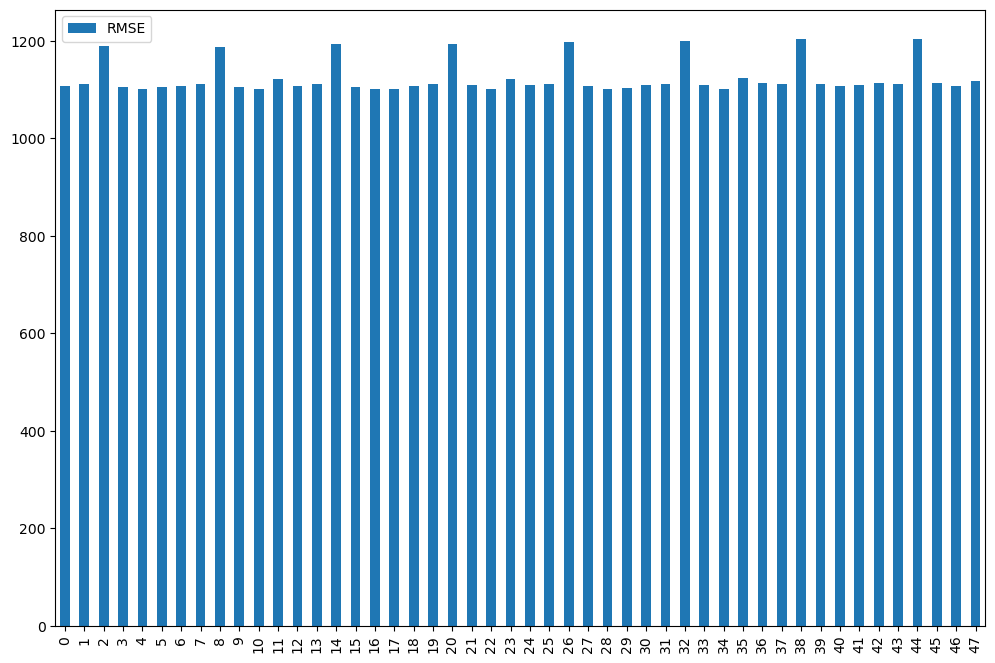

In [153]:
pred_df.plot(kind = "bar", figsize = (12, 8))

All models have high error rates. So, we need to rethink our approach a bit. Let's try to predict `prep_duration` and then calculate `total_delivery_duration`.

### More Feature Engineering

In [154]:
# new approach to the problem, always room for more feature engineering!

train_df['prep_time'] = train_df["total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

In [155]:
# define two dictionaries which contain our parameters, scaler and feature size. As decided earlier, scaler is standard, feature size is 40.

scalers = {
    "Standard Scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by = 'Gini-importance')[-40:].index.tolist(),
}

Create three different `for` loops to select the `feature_set`, `scaler`, and `model name` in their dictionaries. Then define `prep_time` as a target variable and select our features. Note: Since the target variable is derived from `estimated_store_to_consumer_driving_duration` and `estimated_order_place_duration`, we are able to drop these features, avoiding collinearity. 

In [156]:
# drop columns here if not already dropped

# train_df[feature_set].drop(columns=['estimated_store_to_consumer_driving_duration','estimated_order_place_duration'])

# check if columns are dropped
train_df[feature_set].columns

Index(['category_mexican', 'category_indian', 'category_thai',
       'category_chinese', 'category_dessert', 'category_american',
       'category_burger', 'total_items', 'price_range_of_items',
       'total_outstanding_orders'],
      dtype='object')

### Continuing with model selection

In [157]:
# for loop from earlier (modified)
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            # modified to drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
                X = train_df[feature_set]
            
#.drop(columns=['estimated_store_to_consumer_driving_duration','estimated_order_place_duration']) --> option to drop columns here as well
                y = train_df["prep_time"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
                # get indices
                train_indices = X_train.index
                test_indices = X_test.index

                # scale
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X ,y)

                # apply indexing
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size = 0.2,random_state = 42)
            
                _, y_predict_scaled, _, _ = predicting(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled, regression_models[model_name], model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
                pred_dict["regression_model"].append(model_name)
                pred_dict["feature_set"].append(feature_set_name)
                pred_dict["scaler_name"].append(scaler_name)
                pred_dict["RMSE"].append(rmse_error)  

-----scaled with Standard Scaler------- included columns are selected_features_40

Train error = 0.965965986251831 in Ridge
Test error = 0.9583235383033752 in Ridge
Error = 1072.8511962890625 in Ridge
Train error = 0.963977313496515 in DecisionTree
Test error = 0.9610414090617999 in DecisionTree
Error = 1075.8939131266993 in DecisionTree
Train error = 0.5666356289593 in RandomForest
Test error = 1.0337075625978864 in RandomForest
Error = 1157.2442822015507 in RandomForest
Train error = 0.9164329767227173 in XGBoost
Test error = 0.959121823310852 in XGBoost
Error = 1073.7449951171875 in XGBoost
Train error = 0.9506155889940658 in LGBM
Test error = 0.9525853746274646 in LGBM
Error = 1066.4273116789166 in LGBM
Train error = 0.9569829106330872 in MLP
Test error = 0.9530905485153198 in MLP
Error = 1066.9927978515625 in MLP


According to the results, Light GBM is the best performing model, though not by much. So, for our final process, we'll only use LGBM as the model to evaluate. Redo the above calculation once more, using LGBM as our model.

In [158]:
scalers = {
    "Standard Scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by = 'Gini-importance')[-40:].index.tolist(),
}

# use LGBM, the best performing model
regression_models = {
    "LGBM": LGBMRegressor(),
}

# for loop from earlier (modified)
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            # modified to drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
                X = train_df[feature_set]
            
#.drop(columns=['estimated_store_to_consumer_driving_duration','estimated_order_place_duration']) --> option to drop columns here as well
                y = train_df["prep_time"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
                # get indices
                train_indices = X_train.index
                test_indices = X_test.index

                # scale
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X ,y)

                # apply indexing
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size = 0.2,random_state = 42)
            
                _, y_predict_scaled, _, _ = predicting(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled, regression_models[model_name], model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
                pred_dict["regression_model"].append(model_name)
                pred_dict["feature_set"].append(feature_set_name)
                pred_dict["scaler_name"].append(scaler_name)
                pred_dict["RMSE"].append(rmse_error)  

-----scaled with Standard Scaler------- included columns are selected_features_40

Train error = 0.9506155889940658 in LGBM
Test error = 0.9525853746274646 in LGBM
Error = 1066.4273116789166 in LGBM


### Continuing with best model - LGBM

In [159]:
# Now that we have our best model, let's extract `prep_duration` predictions.

pred_values_dict = {
    "total_delivery_duration": train_df["total_delivery_duration"][test_indices].values.tolist(),
    "prep_duration_prediction": y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),
}   

In [160]:
# convert dictionary to dataframe

values_df = pd.DataFrame.from_dict(pred_values_dict) 
values_df 

,total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2478.0,2423.885621,521.0,251.0
1,2063.0,2055.665192,428.0,251.0
2,2873.0,1799.460063,748.0,446.0
3,2883.0,1824.310163,557.0,251.0
4,2356.0,2187.427522,391.0,251.0
...,...,...,...,...
35409,2928.0,2174.722231,473.0,446.0
35410,1691.0,2082.214642,318.0,446.0
35411,3260.0,1932.982071,746.0,251.0
35412,4041.0,2101.824888,382.0,251.0


y_predict is now calculated! now, let's do the math and calculate the sum of total delivery duration by adding `estimated_store_to_consumer_driving_duration` and `estimated_order_place_duration` to the `prep_duration_prediction`

In [161]:
# sum predictions

values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

,total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2478.0,2423.885621,521.0,251.0,3195.885621
1,2063.0,2055.665192,428.0,251.0,2734.665192
2,2873.0,1799.460063,748.0,446.0,2993.460063
3,2883.0,1824.310163,557.0,251.0,2632.310163
4,2356.0,2187.427522,391.0,251.0,2829.427522
...,...,...,...,...,...
35409,2928.0,2174.722231,473.0,446.0,3093.722231
35410,1691.0,2082.214642,318.0,446.0,2846.214642
35411,3260.0,1932.982071,746.0,251.0,2929.982071
35412,4041.0,2101.824888,382.0,251.0,2734.824888


Since we've caluclated the `sum_total_delivery_duration`, let's calculate the mean squared error between the `total_delivery_duration` and the `sum_total_delivery_duration`.

In [162]:
# checking new error rate

mean_squared_error(values_df["total_delivery_duration"], values_df["sum_total_delivery_duration"], squared = False)

1066.4273116789166

The error rate is still way too high! Let's do another approach. We'll use our `prep_duration_prediction` and `estimated_store_to_consumer_driving_duration` to calculate the actual `total_delivery_duration`.

### Revisiting our approach to best model

In [163]:
# Use another regression model to obtain the actual total delivery duration
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [177]:
# define regression models dictionary, adding 6 different regression model names into it

# use a for loop and custom predicting function to select model from our regression model dictionary

regression_models = {
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth = 6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
} # fun models to use!

for model_name in regression_models.keys():
    _, y_predict, _, _ = predicting(
        X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose = False)
    print("RMSE of:", model_name, mean_squared_error(y_test, y_predict, squared = False))

RMSE of: Ridge 1022.2842133239229
RMSE of: DecisionTree 1035.5214939114414
RMSE of: RandomForest 1132.3685399299266
RMSE of: XGBoost 1046.0694001193071
RMSE of: LGBM 1028.6387043277766
RMSE of: MLP 1022.830694906357


In [165]:
# view predictions
values_df['prep_duration_prediction']

0        2423.885621
1        2055.665192
2        1799.460063
3        1824.310163
4        2187.427522
            ...     
35409    2174.722231
35410    2082.214642
35411    1932.982071
35412    2101.824888
35413    1866.817133
Name: prep_duration_prediction, Length: 35414, dtype: float64

This approach has about 50% better performance than our previous attempts, the error rates drop by nearly half of what they were previously. So we'll use this when finding our official solution.

## Deep Learning 

We will use Deep Learning since our model has too many hyper parameters. Use keras and tensorflow to create a model that predicts that actual `total_delivery_duration`.

In [166]:
# use keras and tf to create a neural network

def create_model(feature_set_size):

    # define model
    model = Sequential()
    model.add(Dense(16, input_dim = feature_set_size, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))

    # complile model
    model.compile(optimizer = 'sgd', loss = 'mse', # stochastic gradient descent, mean squared error
        metrics = [tf.keras.metrics.RootMeanSquaredError()])

    return model

In [167]:
# call function
print(f"-----scaled with {scaler_name}------- included columns are {feature_set_name}")
print("")
# get model name, scaler name, and features ready

model_name = "ANN" 
scaler_name = "Standard Scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["total_delivery_duration"]
# split data and apply scaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X ,y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size = 0.2,random_state = 42)
# apply custom function
print("feature_set_size:", X_train_scaled.shape[1])
model = create_model(feature_set_size = X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs = 100, batch_size = 64, verbose = 1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name) # apply rmse with inverse transform since we used a scaler
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)  

-----scaled with Standard Scaler------- included columns are selected_features_40

feature_set_size: 3
Epoch 1/100
443/443 [==============================] - 0s 461us/step - loss: 0.9305 - root_mean_squared_error: 0.9646
Epoch 2/100
443/443 [==============================] - 0s 433us/step - loss: 0.8823 - root_mean_squared_error: 0.9393
Epoch 3/100
443/443 [==============================] - 0s 466us/step - loss: 0.8802 - root_mean_squared_error: 0.9382
Epoch 4/100
443/443 [==============================] - 0s 553us/step - loss: 0.8797 - root_mean_squared_error: 0.9379
Epoch 5/100
443/443 [==============================] - 0s 501us/step - loss: 0.8796 - root_mean_squared_error: 0.9379
Epoch 6/100
443/443 [==============================] - 0s 490us/step - loss: 0.8790 - root_mean_squared_error: 0.9376
Epoch 7/100
443/443 [==============================] - 0s 459us/step - loss: 0.8786 - root_mean_squared_error: 0.9373
Epoch 8/100
443/443 [==============================] - 0s 440us/step - 

Epoch means one cycle over the entire data set. The loss quantifies the differences between actual values and the predicted ones from the entire data set. Now, since we have ran our model, let's draw a graph to see the relation between epoch and loss.

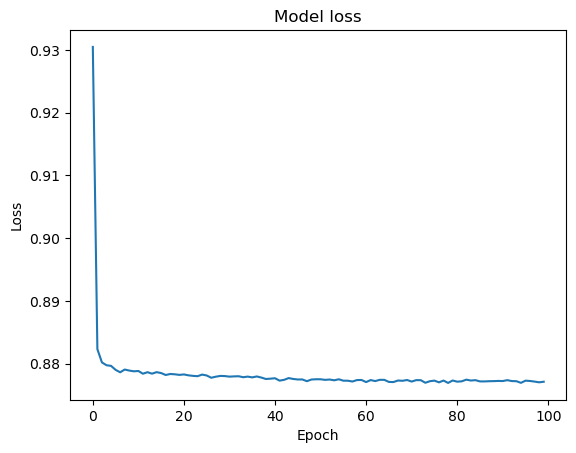

In [168]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

With deep learning, we've found that our result here is similar to our previous best approach solution. So our official solution that we'll use is LGBM + Linear Regression. 

To find better results, we could try:

- Tuning hyperparameters in ANN with various methods

Though, since this model is promising and fast, we will go along with this one, but for future purposes this could vary for project needs.

In [175]:
# turn predictions into csv
values_df['prep_duration_prediction'].to_csv('predictions.csv')